<a href="https://colab.research.google.com/github/kcbharat100/covid-19-detection-using-x-rays/blob/master/covid_19_detection_binary_mobilenet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Accessing dataset from github repo

!git clone https://github.com/kcbharat100/covid-19-detection-using-x-rays.git

Cloning into 'covid-19-detection-using-x-rays'...
remote: Enumerating objects: 30, done.
remote: Counting objects: 100% (30/30), done.
remote: Compressing objects: 100% (28/28), done.
remote: Total 3176 (delta 11), reused 9 (delta 1), pack-reused 3146
Receiving objects: 100% (3176/3176), 916.97 MiB | 15.56 MiB/s, done.
Resolving deltas: 100% (42/42), done.
Checking out files: 100% (1922/1922), done.


In [2]:
# Importing packages and installing libraries

import os
%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import shutil
import random
from numpy.random import seed
import numpy as np
import keras
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout
from keras.layers import Activation, Flatten, Dense
from keras import optimizers
from keras import Model
import tensorflow
from sklearn.metrics import classification_report, confusion_matrix
!pip install eli5
import eli5
from PIL import Image
from IPython.display import display
!pip install split-folders
import split_folders

Using TensorFlow backend.


     |████████████████████████████████| 112kB 2.8MB/s 


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


In [6]:
# Preparing balanced dataset
# Since there are 206 covid images, we are going to use 206 normal images 

seed(1234)
       
def get_file_list(input_dir):
    return [file for file in os.listdir(input_dir) if os.path.isfile(os.path.join(input_dir, file))]

def get_random_files(file_list, N):
    return random.sample(file_list, N)

def copy_files(random_files, input_dir, output_dir):
    for file in random_files:
        shutil.copy(os.path.join(input_dir, file), output_dir)

def select_copy_randomly(input_dir, output_dir, N):
    file_list = get_file_list(input_dir)
    random_files = get_random_files(file_list, N)
    copy_files(random_files, input_dir, output_dir)

def copy_directory_files(input_dir, output_dir):
    files = get_file_list(input_dir)
    copy_files(files, input_dir, output_dir)

def file_count(dir):
  path, dirs, files = next(os.walk(dir))
  return len(files)

input_dir_normal = 'covid-19-detection-using-x-rays/dataset_binary/normal'
input_dir_covid = 'covid-19-detection-using-x-rays/dataset_binary/covid'
output_dir_normal = 'datasett/normal'
output_dir_covid = 'datasett/covid'

if not os.path.exists(output_dir_normal):
    os.makedirs(output_dir_normal)
if not os.path.exists(output_dir_covid):
    os.makedirs(output_dir_covid)
    
# Select and copy randomly 206 images from github dataset to new directory- dataset
select_copy_randomly(input_dir_normal, output_dir_normal, 206)
print("Normal files count:")
print(str(file_count(output_dir_normal)))

# Copy all 206 images from imported github dataset to new directory - dataset
copy_directory_files(input_dir_covid, output_dir_covid )
print("Covid files count:")
print(str(file_count(output_dir_covid)))
print('Done!')

Normal files count:
206
Covid files count:
206
Done!


In [8]:
# Train, validation & Test set split

split_folders.ratio('datasett', output="data", seed=1234, ratio=(.7, .15, .15)) # for train, val, test

Copying files: 412 files [00:00, 620.42 files/s]


In [9]:
# Data preparation

# For reproducibility
tensorflow.random.set_seed(1234)

train_dir = 'data/train'
validation_dir = 'data/val'
test_dir = 'data/test'

img_size = (224,224)  #as per the input image size of mobilenet
batch_size = 32

classes = sorted(os.listdir(train_dir))
print(classes)

print("Getting data...")
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    shear_range=0.2,
    zoom_range=0.25,
    
    fill_mode="nearest"
    )

validation_datagen = ImageDataGenerator(rescale=1.0/255)
test_datagen = ImageDataGenerator(rescale=1.0/255)

print("Preparing trainig dataset...")
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = img_size,
    batch_size = batch_size,
    shuffle = True)

print("Preparing validation dataset...")
validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size = img_size,
    batch_size = batch_size,
    shuffle = True)

print("Preparing test dataset...")
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size = img_size,
    batch_size = batch_size,
    shuffle = False)

['covid', 'normal']
Getting data...
Preparing trainig dataset...
Found 288 images belonging to 2 classes.
Preparing validation dataset...
Found 60 images belonging to 2 classes.
Preparing test dataset...
Found 64 images belonging to 2 classes.


In [10]:
# Mobilenet Model

mobile = keras.applications.mobilenet.MobileNet();
mobile.summary()

17227776/17225924 [==============================] - 2s 0us/step
Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________

In [11]:
# Adding layers to classify our images and modify it by not including last five layers of mobile net;

x = mobile.layers[-6].output
predictions = Dense(2, activation='softmax')(x)
model = Model(inputs = mobile.input, outputs = predictions)
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128 

In [12]:
# Fine tuning:
# freezing all the layers except last 24 layers
# It means only the last 24 layers will be trained
for layer in model.layers[:-24]:
  layer.trainable = False

#View trainable layers 
for layer in model.layers:
  print("{0}:\t{1}".format(layer.trainable, layer.name))

False:	input_1
False:	conv1_pad
False:	conv1
False:	conv1_bn
False:	conv1_relu
False:	conv_dw_1
False:	conv_dw_1_bn
False:	conv_dw_1_relu
False:	conv_pw_1
False:	conv_pw_1_bn
False:	conv_pw_1_relu
False:	conv_pad_2
False:	conv_dw_2
False:	conv_dw_2_bn
False:	conv_dw_2_relu
False:	conv_pw_2
False:	conv_pw_2_bn
False:	conv_pw_2_relu
False:	conv_dw_3
False:	conv_dw_3_bn
False:	conv_dw_3_relu
False:	conv_pw_3
False:	conv_pw_3_bn
False:	conv_pw_3_relu
False:	conv_pad_4
False:	conv_dw_4
False:	conv_dw_4_bn
False:	conv_dw_4_relu
False:	conv_pw_4
False:	conv_pw_4_bn
False:	conv_pw_4_relu
False:	conv_dw_5
False:	conv_dw_5_bn
False:	conv_dw_5_relu
False:	conv_pw_5
False:	conv_pw_5_bn
False:	conv_pw_5_relu
False:	conv_pad_6
False:	conv_dw_6
False:	conv_dw_6_bn
False:	conv_dw_6_relu
False:	conv_pw_6
False:	conv_pw_6_bn
False:	conv_pw_6_relu
False:	conv_dw_7
False:	conv_dw_7_bn
False:	conv_dw_7_relu
False:	conv_pw_7
False:	conv_pw_7_bn
False:	conv_pw_7_relu
False:	conv_dw_8
False:	conv_dw_8_bn
Fals

In [13]:
# Compile
opt = keras.optimizers.Adam
model.compile(optimizer= opt(lr = 1e-5), 
              loss="categorical_crossentropy", 
              metrics=["acc"])

# Train
steps_per_epoch = np.ceil(train_generator.samples/train_generator.batch_size)
val_steps_per_epoch = np.ceil(validation_generator.samples/validation_generator.batch_size)
num_epochs = 30
history = model.fit(
    train_generator, 
    epochs=num_epochs,
    verbose=1,
    steps_per_epoch=steps_per_epoch,
    validation_data=validation_generator,
    validation_steps=val_steps_per_epoch)

Epoch 1/30
9/9 [==============================] - 16s 2s/step - loss: 0.7475 - acc: 0.5972 - val_loss: 0.3740 - val_acc: 0.9000
Epoch 2/30
9/9 [==============================] - 11s 1s/step - loss: 0.4903 - acc: 0.7917 - val_loss: 0.3189 - val_acc: 0.9667
Epoch 3/30
9/9 [==============================] - 12s 1s/step - loss: 0.3073 - acc: 0.8993 - val_loss: 0.2467 - val_acc: 0.9667
Epoch 4/30
9/9 [==============================] - 12s 1s/step - loss: 0.2618 - acc: 0.9201 - val_loss: 0.2185 - val_acc: 0.9833
Epoch 5/30
9/9 [==============================] - 12s 1s/step - loss: 0.1751 - acc: 0.9549 - val_loss: 0.2249 - val_acc: 0.9833
Epoch 6/30
9/9 [==============================] - 12s 1s/step - loss: 0.1539 - acc: 0.9653 - val_loss: 0.1771 - val_acc: 0.9667
Epoch 7/30
9/9 [==============================] - 12s 1s/step - loss: 0.1609 - acc: 0.9410 - val_loss: 0.1873 - val_acc: 0.9667
Epoch 8/30
9/9 [==============================] - 12s 1s/step - loss: 0.1158 - acc: 0.9653 - val_loss: 0

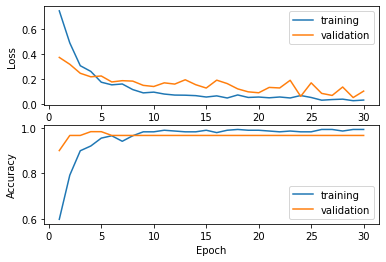

In [14]:
# Plot of training history: loss and accuracy

%matplotlib inline
from matplotlib import pyplot as plt

epoch_nums = range(1,num_epochs+1)
training_loss = history.history["loss"]
validation_loss = history.history["val_loss"]
plt.figure(1)
plt.subplot(211)
plt.plot(epoch_nums, training_loss)
plt.plot(epoch_nums, validation_loss)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['training', 'validation'], loc='upper right')

epoch_nums = range(1,num_epochs+1)
training_accuracy = history.history["acc"]
validation_accuracy = history.history["val_acc"]
plt.subplot(212)
plt.plot(epoch_nums, training_accuracy)
plt.plot(epoch_nums, validation_accuracy)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['training', 'validation'], loc='lower right')
plt.show()

In [15]:
# Measure accuracy and loss on test data
test_steps_per_epoch = np.ceil(test_generator.samples/test_generator.batch_size)

test_loss, test_accuracy = model.evaluate(test_generator, steps = test_steps_per_epoch)
print("Test loss: {:.2f}".format(test_loss))
print("Test accuracy: {:.2f}%".format(test_accuracy * 100))

2/2 [==============================] - 2s 821ms/step
Test loss: 0.06
Test accuracy: 100.00%


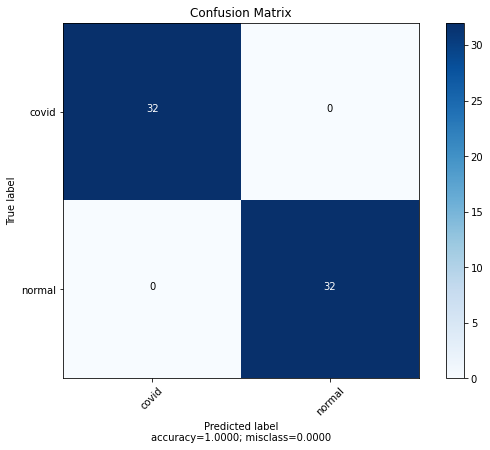

Classification Report:
              precision    recall  f1-score   support

       covid       1.00      1.00      1.00        32
      normal       1.00      1.00      1.00        32

    accuracy                           1.00        64
   macro avg       1.00      1.00      1.00        64
weighted avg       1.00      1.00      1.00        64



In [16]:
# Confusion matrix and classification report

def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=False):
    

    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

Predictions = model.predict_generator(test_generator, steps= test_steps_per_epoch, verbose=0)
predictions = Predictions.argmax(axis=1)
test_labels = test_generator.classes
cm = confusion_matrix(test_labels, predictions)
cm_plot_labels = list(train_generator.class_indices)
plot_confusion_matrix(cm, cm_plot_labels, title = 'Confusion Matrix')

print('Classification Report:')
target_names = list(train_generator.class_indices)
print(classification_report(test_generator.classes, predictions, target_names=target_names))

(None, 224, 224, 3)
(224, 224)
Test Image


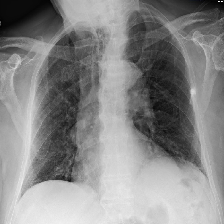

{'covid': 0, 'normal': 1}
Prediction confidence:
[[0.90585035 0.09414968]]

Heat map of Test Image


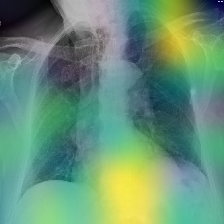

In [64]:
#Prediction and Heatmap

# # check the input format
print(model.input_shape)
dims = model.input_shape[1:3] # -> (height, width)
print(dims)

image = '/content/data/test/covid/figure1-5e75d0940b71e1b702629659-98-right.jpeg'

im = keras.preprocessing.image.load_img(image, target_size=dims) # -> PIL image
print("Test Image")
display(im)
doc = keras.preprocessing.image.img_to_array(im) # -> numpy array

doc = np.expand_dims(doc, axis=0)

# make a prediction about our sample image
predictions = model.predict(doc)

classes = train_generator.class_indices
print(classes)
print("Prediction confidence:")
print(predictions)

#But how did the network know that? Let’s check where the model “looked” for a dog with ELI5:
print("\nHeat map of Test Image")
eli5.show_prediction(model, doc)

In [55]:
# Utility function for obtaining of the errors 

def obtain_errors(test_gen, predictions):
    # Get the filenames from the generator
    fnames = test_gen.filenames

    # Get the ground truth from generator
    ground_truth = test_gen.classes

    # Get the dictionary of classes
    label2index = test_gen.class_indices

    # Obtain the list of the classes
    idx2label = list(label2index.keys())
    print("The list of classes: ", idx2label)

    # Get the class index
    predicted_classes = np.argmax(predictions, axis=1)

    errors = np.where(predicted_classes != ground_truth)[0]
    print("Number of errors = {}/{}".format(len(errors),test_gen.samples))
    
    return idx2label, errors, fnames


# Utility function for visualization of the errors
def show_errors(idx2label, errors, predictions, fnames, directory):
    # Show the errors
    for i in range(len(errors)):
        pred_class = np.argmax(predictions[errors[i]])
        pred_label = idx2label[pred_class]

        title = 'Original label:{}, Prediction :{}, confidence : {:.3f}'.format(
            fnames[errors[i]].split('/')[0],
            pred_label,
            predictions[errors[i]][pred_class])

        # original = load_img('{}/{}'.format(validation_dir,fnames[errors[i]]))
        img = mpimg.imread('{}/{}'.format(directory,fnames[errors[i]]))
        
        plt.figure(figsize=[7,7])
        plt.axis('off')
        plt.title(title)
        # plt.imshow(original)
        plt.imshow(img) 
        plt.show()

# Get the predictions from the model using the generator
predictions = model.predict(test_generator, steps= test_steps_per_epoch)

dir = test_dir

# Run the function to get the list of classes and errors
idx2label, errors, fnames = obtain_errors(test_generator, predictions)

# Run the function to illustrate the error cases
show_errors(idx2label, errors, predictions, fnames, dir)

The list of classes:  ['covid', 'normal']
Number of errors = 0/64


In [59]:
#Saving and exportingmodel

import tensorflow as tf

model.save('model_covid_binary_mobilenet.hdf5')

model_loaded = tf.keras.models.load_model('model_covid_binary_mobilenet.hdf5')

# Save the model
export_dir = "/tmp/test_saved_model"
tf.saved_model.save(model_loaded, export_dir)

#Converting keras model into tflite
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()
tflite_model_file = 'converted_model_covid_binary_mobilenet.tflite'

with open(tflite_model_file, "wb") as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/test_saved_model/assets


INFO:tensorflow:Assets written to: /tmp/test_saved_model/assets


In [65]:
!zip -r ./test_images.zip ./data/test

  adding: data/test/ (stored 0%)
  adding: data/test/normal/ (stored 0%)
  adding: data/test/normal/NORMAL2-IM-0929-0001.jpeg (deflated 1%)
  adding: data/test/normal/IM-0697-0001.jpeg (deflated 1%)
  adding: data/test/normal/IM-0347-0001.jpeg (deflated 1%)
  adding: data/test/normal/IM-0593-0001.jpeg (deflated 1%)
  adding: data/test/normal/NORMAL2-IM-1242-0001.jpeg (deflated 1%)
  adding: data/test/normal/IM-0224-0001.jpeg (deflated 0%)
  adding: data/test/normal/IM-0180-0001.jpeg (deflated 0%)
  adding: data/test/normal/NORMAL2-IM-0633-0001.jpeg (deflated 1%)
  adding: data/test/normal/IM-0714-0001.jpeg (deflated 1%)
  adding: data/test/normal/NORMAL2-IM-0618-0001.jpeg (deflated 1%)
  adding: data/test/normal/NORMAL2-IM-1350-0001.jpeg (deflated 1%)
  adding: data/test/normal/IM-0345-0001.jpeg (deflated 0%)
  adding: data/test/normal/NORMAL2-IM-1067-0001-0001.jpeg (deflated 6%)
  adding: data/test/normal/NORMAL2-IM-0642-0001.jpeg (deflated 1%)
  adding: data/test/normal/NORMAL2-IM-13

In [66]:
from google.colab import files
files.download("test_images.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [67]:
# Class labels
from google.colab import files

labels = '\n'.join(sorted(train_generator.class_indices.keys()))

with open('labels.txt', 'w') as f:
  f.write(labels)
  
files.download('labels.txt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>